##  Objectives
In this worksheet, you will:
1. Define loss functions for three optimization problems.
2. Apply three optimization algorithms: **SGD with Momentum**, **Adam**, and **RMSProp**.
3. Record the number of iterations needed for convergence.
4. Compare convergence speed and stability across optimizers.

In [197]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Quadratic function generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    """Generate symmetric positive definite Q with given condition number."""
    V = np.linalg.qr(np.random.randn(dim, dim))[0]  # orthogonal matrix
    eigvals = np.linspace(1, cond_number, dim)      # spread of eigenvalues
    Q = V @ np.diag(eigvals) @ V.T
    return Q

# Quadratic function and gradient
def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# Rosenbrock function and gradient
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# -------------------------------
# Optimizers
# -------------------------------
def sgd_momentum(f_grad, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    history = []
    for i in range(max_iter):
        grad = f_grad(x)
        v = beta * v + (1 - beta) * grad
        x -= lr * v
        history.append(i)
        if np.linalg.norm(grad) < tol:
            break
    return x, i + 1, history

def adam(f_grad, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    history = []
    for t in range(1, max_iter + 1):
        g = f_grad(x)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
        history.append(t)
        if np.linalg.norm(g) < tol:
            break
    return x, t, history

def rmsprop(f_grad, x0, lr=0.001, beta=0.9, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    history = []
    for i in range(max_iter):
        g = f_grad(x)
        s = beta * s + (1 - beta) * (g ** 2)
        x -= lr * g / (np.sqrt(s) + eps)
        history.append(i)
        if np.linalg.norm(g) < tol:
            break
    return x, i + 1, history

def test(f_grad, x0, lr=0.001, beta=0.8, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    update = np.zeros_like(x)

    alpha_sgd = 0.001
    alpha_nes = 0.001
    beta_nes = 0.9

    mean_g = np.zeros_like(x)
    var_g = np.zeros_like(x)
    beta_mean = 0.99
    beta_var = 0.99

    history = []

    for i in range(max_iter):
        g = f_grad(x)

        step_sgd = alpha_sgd * g

        x_look = x - beta_nes * update
        g_la = f_grad(x_look)
        update = beta_nes * update + alpha_nes * g_la
        step_nes = update

        mean_g = beta_mean * mean_g + (1 - beta_mean) * g
        var_g = beta_var * var_g + (1 - beta_var) * (g - mean_g)**2

        gv_weight = var_g / (var_g + eps)
        gv_weight = np.clip(gv_weight, 0, 1)

        dot = np.dot(step_sgd, step_nes)
        norm = (np.linalg.norm(step_sgd) * np.linalg.norm(step_nes) + eps)
        cos_sim = dot / norm
        cs_weight = (1 + cos_sim) / 2

        blend_w = 0.5 * gv_weight + 0.5 * cs_weight
        step = blend_w * step_nes + (1 - blend_w) * step_sgd
        x -= step

        if np.linalg.norm(g) < tol:
            break

    return x, i + 1, history

# -------------------------------
# Experiment Runner
# -------------------------------
def run_experiment(f, grad_f, x0, optimizers, tol, f_name):
    results = {}
    for name, opt in optimizers.items():
        x_opt, n_iter, history = opt(grad_f, x0)
        results[name] = n_iter
        print(f"{f_name} | {name} converged in {n_iter} iterations.")
    return results

# -------------------------------
# 1️ Well-conditioned Quadratic
# -------------------------------
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda g, x0: sgd_momentum(lambda x: quadratic_grad(x, Q_well), x0),
    "Adam": lambda g, x0: adam(lambda x: quadratic_grad(x, Q_well), x0),
    "RMSProp": lambda g, x0: rmsprop(lambda x: quadratic_grad(x, Q_well), x0),
    "TEST": lambda g, x0: test(lambda x: quadratic_grad(x, Q_well), x0),
}
print("\n--- Well-Conditioned Quadratic ---")
run_experiment(lambda x: quadratic_f(x, Q_well), lambda x: quadratic_grad(x, Q_well), x0, optimizers, tol=1e-6, f_name="Well-conditioned")

# -------------------------------
# 2️ Ill-conditioned Quadratic
# -------------------------------
Q_ill = generate_quadratic(dim, cond_number=100)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda g, x0: sgd_momentum(lambda x: quadratic_grad(x, Q_ill), x0),
    "Adam": lambda g, x0: adam(lambda x: quadratic_grad(x, Q_ill), x0),
    "RMSProp": lambda g, x0: rmsprop(lambda x: quadratic_grad(x, Q_ill), x0),
    "TEST": lambda g, x0: rmsprop(lambda x: quadratic_grad(x, Q_ill), x0),
}
print("\n--- Ill-Conditioned Quadratic ---")
run_experiment(lambda x: quadratic_f(x, Q_ill), lambda x: quadratic_grad(x, Q_ill), x0, optimizers, tol=1e-6, f_name="Ill-conditioned")

# -------------------------------
# 3️ Rosenbrock Function
# -------------------------------
x0 = np.array([-1.2, 1.0])
optimizers = {
    "SGD+Momentum": lambda g, x0: sgd_momentum(rosenbrock_grad, x0, lr=0.001, tol=1e-4),
    "Adam": lambda g, x0: adam(rosenbrock_grad, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda g, x0: rmsprop(rosenbrock_grad, x0, lr=0.001, tol=1e-4),
    "TEST": lambda g, x0: test(rosenbrock_grad, x0, lr=0.001, tol=1e-4),
}
print("\n--- Rosenbrock Function ---")
run_experiment(rosenbrock_f, rosenbrock_grad, x0, optimizers, tol=1e-4, f_name="Rosenbrock")



--- Well-Conditioned Quadratic ---
Well-conditioned | SGD+Momentum converged in 1193 iterations.
Well-conditioned | Adam converged in 6261 iterations.
Well-conditioned | RMSProp converged in 10000 iterations.
Well-conditioned | TEST converged in 1523 iterations.

--- Ill-Conditioned Quadratic ---
Ill-conditioned | SGD+Momentum converged in 1203 iterations.
Ill-conditioned | Adam converged in 10000 iterations.
Ill-conditioned | RMSProp converged in 10000 iterations.
Ill-conditioned | TEST converged in 10000 iterations.

--- Rosenbrock Function ---
Rosenbrock | SGD+Momentum converged in 10000 iterations.
Rosenbrock | Adam converged in 10000 iterations.
Rosenbrock | RMSProp converged in 10000 iterations.
Rosenbrock | TEST converged in 2469 iterations.


{'SGD+Momentum': 10000, 'Adam': 10000, 'RMSProp': 10000, 'TEST': 2469}


--- Well-Conditioned Quadratic ---
Well-Conditioned Quadratic | SGD+Momentum converged in 1220 iterations.
Well-Conditioned Quadratic | Adam converged in 1569 iterations.
Well-Conditioned Quadratic | RMSProp converged in 10000 iterations.
Well-Conditioned Quadratic | TEST converged in 1541 iterations.


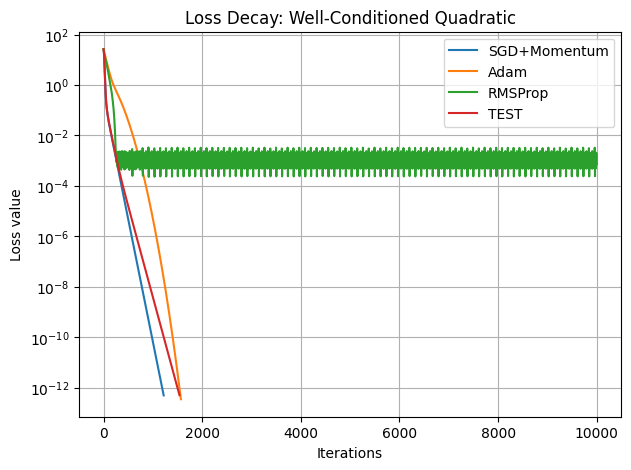


--- Ill-Conditioned Quadratic ---
Ill-Conditioned Quadratic | SGD+Momentum converged in 10000 iterations.
Ill-Conditioned Quadratic | Adam converged in 8860 iterations.
Ill-Conditioned Quadratic | RMSProp converged in 10000 iterations.
Ill-Conditioned Quadratic | TEST converged in 1302 iterations.


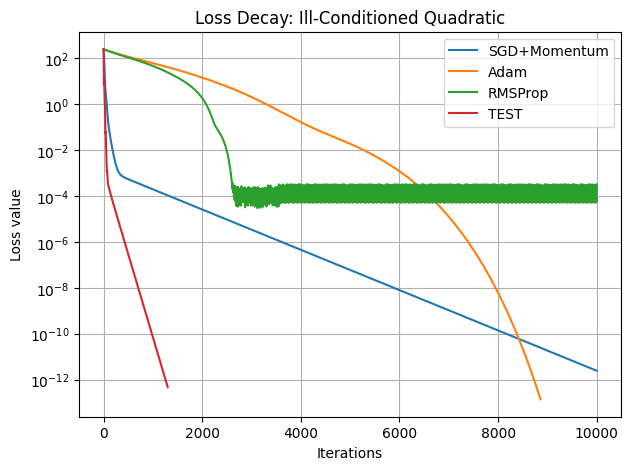


--- Rosenbrock Function ---
Rosenbrock Function | SGD+Momentum converged in 10000 iterations.
Rosenbrock Function | Adam converged in 10000 iterations.
Rosenbrock Function | RMSProp converged in 10000 iterations.
Rosenbrock Function | TEST converged in 2469 iterations.


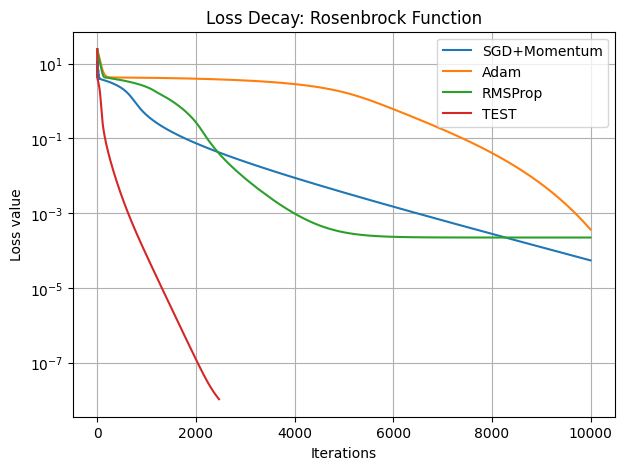

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Quadratic function generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    """Generate symmetric positive definite Q with given condition number."""
    V = np.linalg.qr(np.random.randn(dim, dim))[0]  # orthogonal matrix
    eigvals = np.linspace(1, cond_number, dim)      # spread of eigenvalues
    Q = V @ np.diag(eigvals) @ V.T
    return Q

# Quadratic function and gradient
def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# Rosenbrock function and gradient
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# -------------------------------
# Optimizers (with loss tracking)
# -------------------------------
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta * v + (1 - beta) * g
        x -= lr * v
    return x, i + 1, losses

def adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []
    for t in range(1, max_iter + 1):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.001, beta=0.9, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        s = beta * s + (1 - beta) * (g ** 2)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i + 1, losses

def test(f, f_grad, x0, lr=0.001, beta=0.8, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    update = np.zeros_like(x)

    alpha_sgd = 0.001
    alpha_nes = 0.001
    beta_nes = 0.9

    mean_g = np.zeros_like(x)
    var_g = np.zeros_like(x)
    beta_mean = 0.99
    beta_var = 0.99

    history = []

    for i in range(max_iter):
        loss = f(x)
        history.append(loss)

        g = f_grad(x)

        step_sgd = alpha_sgd * g

        x_look = x - beta_nes * update
        g_la = f_grad(x_look)
        update = beta_nes * update + alpha_nes * g_la
        step_nes = update

        mean_g = beta_mean * mean_g + (1 - beta_mean) * g
        var_g = beta_var * var_g + (1 - beta_var) * (g - mean_g)**2

        gv_weight = var_g / (var_g + eps)
        gv_weight = np.clip(gv_weight, 0, 1)

        dot = np.dot(step_sgd, step_nes)
        norm = (np.linalg.norm(step_sgd) * np.linalg.norm(step_nes) + eps)
        cos_sim = dot / norm
        cs_weight = (1 + cos_sim) / 2

        blend_w = 0.5 * gv_weight + 0.5 * cs_weight
        step = blend_w * step_nes + (1 - blend_w) * step_sgd
        x -= step

        if np.linalg.norm(g) < tol:
            break

    return x, i + 1, history


# -------------------------------
# Experiment Runner + Plotter
# -------------------------------
def run_and_plot(f, grad_f, x0, optimizers, tol, f_name, logy=True):
    plt.figure(figsize=(7, 5))
    for name, opt in optimizers.items():
        x_opt, n_iter, losses = opt(f, grad_f, x0)
        print(f"{f_name} | {name} converged in {n_iter} iterations.")
        plt.plot(losses, label=name)
    if logy:
        plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Loss value")
    plt.title(f"Loss Decay: {f_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# 1️1 Well-conditioned Quadratic
# -------------------------------
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.01),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.01),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.01),
    "TEST": lambda f, g, x0=x0: test(f, g, x0),
}
print("\n--- Well-Conditioned Quadratic ---")
run_and_plot(lambda x: quadratic_f(x, Q_well),
             lambda x: quadratic_grad(x, Q_well),
             x0, optimizers, tol=1e-6, f_name="Well-Conditioned Quadratic")

# -------------------------------
# 2️⃣ Ill-conditioned Quadratic
# -------------------------------
Q_ill = generate_quadratic(dim, cond_number=100)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001),
    "TEST": lambda f, g, x0=x0: test(f, g, x0)
}
print("\n--- Ill-Conditioned Quadratic ---")
run_and_plot(lambda x: quadratic_f(x, Q_ill),
             lambda x: quadratic_grad(x, Q_ill),
             x0, optimizers, tol=1e-6, f_name="Ill-Conditioned Quadratic")

# -------------------------------
# 3️⃣ Rosenbrock Function
# -------------------------------
x0 = np.array([-1.2, 1.0])
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, tol=1e-4),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, tol=1e-4),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, tol=1e-4),
    "TEST": lambda f, g, x0=x0: test(f, g, x0, tol=1e-4)
}
print("\n--- Rosenbrock Function ---")
run_and_plot(rosenbrock_f, rosenbrock_grad, x0, optimizers, tol=1e-4, f_name="Rosenbrock Function")
